###### Lab 3: Residual layers and Squeeze and Excitation
# Chanapa Pananookooln | st121395

In [36]:
import torch
import torchvision
from torchvision import datasets, models, transforms
from torch.utils.data import DataLoader, Dataset, TensorDataset
import torch.nn as nn
import torch.optim as optim
import time
import os
from copy import copy
from copy import deepcopy
import torch.nn.functional as F
import numpy as np
import random
import matplotlib.pyplot as plt 

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cuda:0


## Introduction

This lab is about the ResNet and ResSENet models whose architecture include many residual blocks with different topologies for example the basic residual blocks, Squeeze and Excitation blocks or the Bottleneck blocks.

We learned from the SENet paper that ResNet with SE blocks should be able to train and converge faster than normal ResNet.

The second part of the lab is about transfer learning as we have to fine-tune our trained ResSENet model that we previously trained on the CIFAR-10 dataset on a very small dataset, which is the Chihuahua vs Muffin datasets.

As the dataset that we want to use to train the model is really small we should use multiple folds cross-validation to get the average accuracy over the 8 folds and find the best hyperparameters.

For ResNet18 and ResSENet18 I need to set up these following class, one class per in 1 .py file.

In [23]:
# basic_block.py

class BasicBlock(nn.Module):
    '''
    BasicBlock: Simple residual block with two conv layers
    '''
    EXPANSION = 1
    def __init__(self, in_planes, out_planes, stride=1):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)

        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3, stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)

        self.shortcut = nn.Sequential()
        # If output size is not equal to input size, reshape it with 1x1 convolution
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out += self.shortcut(x) #addition first
        out = F.relu(out) # then ReLU
        return out

#### For ResNet class there are 2 points where we need to edit to match with the architecture described in the paper
#### - Change the initial convolution kernel size to 7
#### - Add MaxPooling layer after BatchNorm2d
#### Then I ran the code to check that the shapes of the outputs of all layers match with the shapes in the paper.

In [24]:
# ResNet.py

class ResNet(nn.Module):
    def __init__(self, block, num_blocks, num_classes=10):
        super().__init__()
        self.in_planes = 64

        # ***Initial convolution***
        self.conv1 = nn.Conv2d(3, 64, kernel_size=7, stride=2, padding=3, bias=False) # changed the kernel size to 7 to match the paper
        self.bn1 = nn.BatchNorm2d(64)
        self.maxpool = nn.MaxPool2d(kernel_size=3, stride=2, padding = 1) # added maxpool layer to math the paper

        # Residual blocks
        self.layer1 = self._make_layer(block, 64, num_blocks[0], stride=1)
        self.layer2 = self._make_layer(block, 128, num_blocks[1], stride=2)
        self.layer3 = self._make_layer(block, 256, num_blocks[2], stride=2)
        self.layer4 = self._make_layer(block, 512, num_blocks[3], stride=2)

        # FC layer = 1 layer
        self.avgpool = nn.AdaptiveAvgPool2d((1, 1))
        self.linear = nn.Linear(512 * block.EXPANSION, num_classes)

    def _make_layer(self, block, planes, num_blocks, stride):
        strides = [stride] + [1] * (num_blocks-1)
        layers = []
        for stride in strides:
            layers.append(block(self.in_planes, planes, stride))
            self.in_planes = planes * block.EXPANSION
        return nn.Sequential(*layers)

    def forward(self, x):
        out = self.bn1(self.conv1(x))
        out = self.maxpool(out)
        out = F.relu(out)

        out = self.layer1(out)
        out = self.layer2(out)
        out = self.layer3(out)
        out = self.layer4(out)
        out = self.avgpool(out)
        out = out.view(out.size(0), -1)
        out = self.linear(out)
        return out

In [25]:
# SElayer.py

class SELayer(nn.Module):
    def __init__(self, channel, reduction=16):
        super().__init__()
        self.avg_pool = nn.AdaptiveAvgPool2d(1)
        self.fc = nn.Sequential(
            nn.Linear(channel, channel // reduction, bias=False),
            nn.ReLU(inplace=True),
            nn.Linear(channel // reduction, channel, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        b, c, _, _ = x.size()
        y = self.avg_pool(x).view(b, c)
        y = self.fc(y).view(b, c, 1, 1)
        return x * y.expand_as(x)

In [26]:
# ResidualSEblock.py

class ResidualSEBasicBlock(nn.Module):
    '''
    ResidualSEBasicBlock: Standard two-convolution residual block with an SE Module between the
                          second convolution and the identity addition
    '''
    EXPANSION = 1

    def __init__(self, in_planes, out_planes, stride=1, reduction=16):
        super().__init__()
        self.conv1 = nn.Conv2d(in_planes, out_planes, kernel_size=3, stride=stride, padding=1, bias=False)
        self.bn1 = nn.BatchNorm2d(out_planes)

        self.conv2 = nn.Conv2d(out_planes, out_planes, kernel_size=3,
                               stride=1, padding=1, bias=False)
        self.bn2 = nn.BatchNorm2d(out_planes)
        self.se = SELayer(out_planes, reduction)

        self.shortcut = nn.Sequential()
        # If output size is not equal to input size, reshape it with a 1x1 conv
        if stride != 1 or in_planes != out_planes:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, out_planes, kernel_size=1, stride=stride, bias=False),
                nn.BatchNorm2d(self.EXPANSION * out_planes)
            )

    def forward(self, x):
        out = F.relu(self.bn1(self.conv1(x)))
        out = self.bn2(self.conv2(out))
        out = self.se(out)              # se net add here
        out += self.shortcut(x)         # shortcut just plus it!!!
        out = F.relu(out)
        return out


## Implementing ResNet18 and ResSENet18 with the architecture provided in class

In [27]:
def ResNet18(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with two sets of two convolutions each: 2*2 + 2*2 + 2*2 + 2*2 = 16 conv layers
    last FC layer: 1
    Total layers: 1+16+1 = 18
    '''
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

def ResSENet18(num_classes = 10):
    return ResNet(ResidualSEBasicBlock, [2, 2, 2, 2], num_classes)

#### For the train function I removed the argument is_inception and its related if and else loop to avoid confusion.

In [28]:
# train.py

def train_model(model, dataloaders, criterion, optimizer, num_epochs, device, weights_name='weight_save'):
    '''
    train_model: train a model on a dataset
    
            Parameters:
                    model: Pytorch model
                    dataloaders: dataset
                    criterion: loss function
                    optimizer: update weights function
                    num_epochs: number of epochs
                    weights_name: file name to save weights
                    is_inception: The model is inception net (Google LeNet) or not

            Returns:
                    model: Best model from evaluation result
                    val_acc_history: evaluation accuracy history
                    loss_acc_history: loss value history
    '''
    since = time.time()

    val_acc_history = []
    loss_acc_history = []

    best_model_wts = deepcopy(model.state_dict())
    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # for process anything, device and dataset must put in the same place.
                # If the model is in GPU, input and output must set to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                # it uses for update training weights
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()
            
            elapsed_epoch = epoch_end - epoch_start

            print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            print("Epoch time taken: ", elapsed_epoch)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                best_model_wts = deepcopy(model.state_dict())
                torch.save(model.state_dict(), weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                loss_acc_history.append(epoch_loss)

        print()

    time_elapsed = time.time() - since
    print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    model.load_state_dict(best_model_wts)
    return model, val_acc_history, loss_acc_history

In [29]:
# test.py

def test_model(model, dataloaders, criterion, device):
    '''
    train_model function

    Train a PyTorch model for a given number of epochs.
    
            Parameters:
                    model: Pytorch model
                    dataloaders: dataset
                    criterion: loss function
                    optimizer: update weights function
                    num_epochs: number of epochs
                    weights_name: file name to save weights
                    is_inception: The model is inception net (Google LeNet) or not

            Returns:
                    model: Best model from evaluation result
                    val_acc_history: evaluation accuracy history
                    loss_acc_history: loss value history
    '''
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
            
    for inputs, labels in dataloaders['test']:

        # Inputs is one batch of input images, and labels is a corresponding vector of integers
        # labeling each image in the batch. First, we move these tensors to our target device.
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

        # Gather our summary statistics        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / len(dataloaders['test'].dataset)
    test_acc = running_corrects.double() / len(dataloaders['test'].dataset)
    test_end = time.time()

    print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', test_loss, test_acc))

    return test_acc, test_loss

## Training 

#### For data augmentation I changed to 256x256 scaling and 224x224 cropping for CIFAR which were the standard augmentation for ImageNet
#### I used the magic nummber to normalize all of the dataset.
#### This time we used different transformation for the training and validation, test set.
#### For the training set I used RandomCrop and RandomHorizontalFlip
#### but for the validation and test set I only used CenterCrop.

#### As this is still a classification problem, we use CrossEntropyLoss() as the loss function
#### For the optimizer I tried training ResNet18 and ResSENet18 with Adam and SGD, with different hyperparamaters.
#### I trained each of the model configurations for 25 EPOCHS.
#### With BATCH_SIZE = 16 and NUM_WORKERS = 2
#### The training results will be shown in the following part.

In [ ]:
# main.py
# used for training the ResNet18 and ResSENet18

#%%
import torch
import torchvision
from torchvision import datasets, models, transforms
import torch.nn as nn
import torch.optim as optim
import time
import os
from copy import copy
from copy import deepcopy
import torch.nn.functional as F
import numpy as np

# Set device to GPU

device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

#%%
# Switch to 256x256 scaling and 224x224 cropping for CIFAR as standardized for ImageNet.***
# use different data augmentation for training and validation set
train_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

eval_preprocess = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize((0.4914, 0.4822, 0.4465), (0.2023, 0.1994, 0.2010))])

# Download CIFAR-10 and split into training, validation, and test sets.
# The copy of the training dataset after the split allows us to keep
# the same training/validation split of the original training set but
# apply different transforms to the training set and validation set.

full_train_dataset = torchvision.datasets.CIFAR10(root='/root/labs/data', train=True,
                                                  download=True)

train_dataset, val_dataset = torch.utils.data.random_split(full_train_dataset, [40000, 10000])
train_dataset.dataset = copy(full_train_dataset)
train_dataset.dataset.transform = train_preprocess
val_dataset.dataset.transform = eval_preprocess

test_dataset = torchvision.datasets.CIFAR10(root='/root/labs/data', train=False,
                                            download=True, transform=eval_preprocess)

# DataLoaders for the three datasets
BATCH_SIZE = 16
NUM_WORKERS = 2

train_dataloader = torch.utils.data.DataLoader(train_dataset, batch_size=BATCH_SIZE,
                                            shuffle=True, num_workers=NUM_WORKERS)
val_dataloader = torch.utils.data.DataLoader(val_dataset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=NUM_WORKERS)
test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size=BATCH_SIZE,
                                            shuffle=False, num_workers=NUM_WORKERS)

dataloaders = {'train': train_dataloader, 'val': val_dataloader}

#%%
# Import the classes from other .py files in the project
from ResNet import ResNet
from basic_block import BasicBlock
from SElayer import SELayer
from ResidualSEblock import ResidualSEBasicBlock

def ResNet18(num_classes = 10):
    '''
    First conv layer: 1
    4 residual blocks with two sets of two convolutions each: 2*2 + 2*2 + 2*2 + 2*2 = 16 conv layers
    last FC layer: 1
    Total layers: 1+16+1 = 18
    '''
    return ResNet(BasicBlock, [2, 2, 2, 2], num_classes)

def ResSENet18(num_classes = 10):
    return ResNet(ResidualSEBasicBlock, [2, 2, 2, 2], num_classes)

#%%
from train import train_model

resnet = ResSENet18().to(device)

# Optimizer and loss function
criterion = nn.CrossEntropyLoss()
params_to_update = resnet.parameters()
optimizer = optim.SGD(params_to_update, lr=0.01, weight_decay=0.0005)

best_model, val_acc_history, loss_history = train_model(model = resnet,
                                                            dataloaders = dataloaders,
                                                            criterion = criterion,
                                                            optimizer = optimizer,
                                                            num_epochs = 25,
                                                            device = device, 
                                                            weights_name='resnetSEADAMdecay_bestsofar')
#%%
# Save the validation accuracy history and the training loss history
val_acc_history = np.array(val_acc_history)
np.save('resnetSEADMdecay_val_acc_history.npy', val_acc_history)

loss_history = np.array(loss_history)
np.save('resnetSEADAMdecay_loss_history.npy', loss_history)


# %%
# load the model to test
from test import test_model

resnet.load_state_dict(torch.load('../../weights/resnet/resnetSEADAMdecay_bestsofar.pth'))

test_dataloaders = { 'test': test_dataloader }
test_acc, test_loss = test_model(resnet, test_dataloaders, criterion, device)


#### After running the main.py, I will have the validation accuracy history and the training loss history saved for plotting and also the saved trained model for further training.

## Evidence of training in VSCODE
#### just some examples



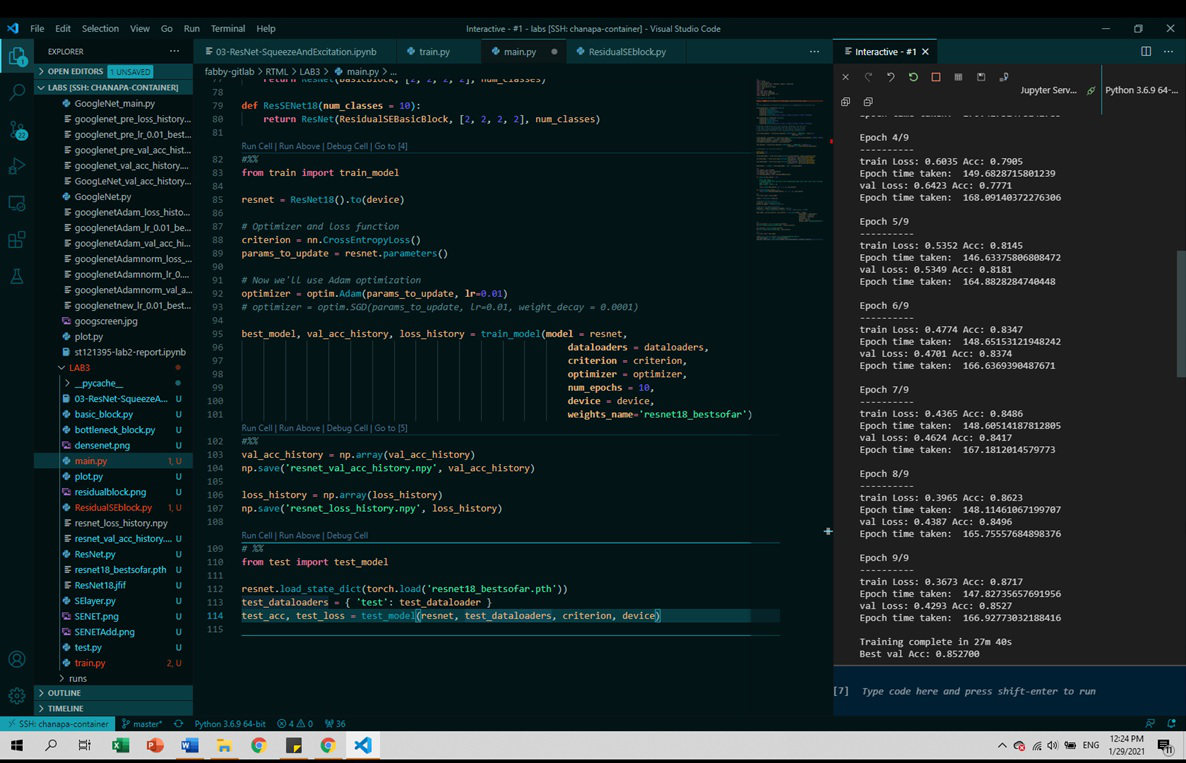

In [59]:
from IPython.display import display
from PIL import Image
display(Image.open("screentrain.jpg"))

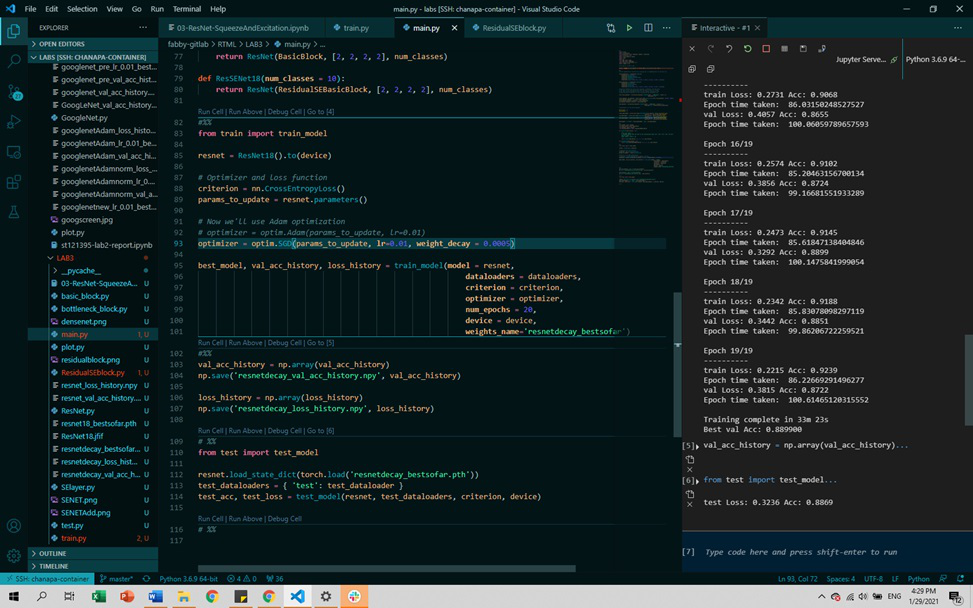

In [12]:
display(Image.open("screentrain2.jpg"))

## Results of training ResNet18 and ResSENet18 with different hyperparameters for the optimizer

## ResNet18

optimizer = optim.SGD(params_to_update, lr=0.01)

        Epoch 24/24
        ----------
        train Loss: 0.1491 Acc: 0.9489
        Epoch time taken:  90.3700704574585
        val Loss: 0.3128 Acc: 0.9044
        Epoch time taken:  104.58276963233948

        Training complete in 41m 45s
        Best val Acc: 0.904400
        test Loss: 0.3252 Acc: 0.8961


optimizer = optim.SGD(params_to_update, lr=0.01, weight_decay = 0.0005)

        Epoch 24/24
        ----------
        train Loss: 0.1689 Acc: 0.9425
        Epoch time taken:  83.80894804000854
        val Loss: 0.2996 Acc: 0.9009
        Epoch time taken:  96.34037446975708

        Training complete in 40m 15s
        Best val Acc: 0.900900
        test Loss: 0.2980 Acc: 0.9014


optimizer = optim.Adam(params_to_update, lr=0.01)

        Epoch 24/24
        ----------
        train Loss: 0.1456 Acc: 0.9494
        Epoch time taken:  102.46131730079651
        val Loss: 0.3964 Acc: 0.8886
        Epoch time taken:  116.08604502677917

        Training complete in 49m 22s
        Best val Acc: 0.890200
        test Loss: 0.4045 Acc: 0.8802


optimizer = optim.Adam(params_to_update, lr=0.01, weight_decay = 0.0005)

        Epoch 24/24
        ----------
        train Loss: 0.1456 Acc: 0.9494
        Epoch time taken:  102.46131730079651
        val Loss: 0.3964 Acc: 0.8886
        Epoch time taken:  116.08604502677917

        Training complete in 49m 22s
        Best val Acc: 0.890200
        test Loss: 0.4045 Acc: 0.8802




## ResSENet18

optimizer = optim.SGD(params_to_update, lr=0.01)

        Epoch 24/24
        ----------
        train Loss: 0.1696 Acc: 0.9399
        Epoch time taken:  99.59944200515747
        val Loss: 0.3905 Acc: 0.8774
        Epoch time taken:  112.15267419815063

        Training complete in 47m 40s
        Best val Acc: 0.891700
        test Loss: 0.3336 Acc: 0.8881


optimizer = optim.SGD(params_to_update, lr=0.01, weight_decay = 0.0005)

        Epoch 24/24
        ----------
        train Loss: 0.1970 Acc: 0.9318
        Epoch time taken:  100.84356188774109
        val Loss: 0.3429 Acc: 0.8895
        Epoch time taken:  113.9784882068634

        Training complete in 47m 13s
        Best val Acc: 0.901600
        test Loss: 0.3262 Acc: 0.8905

optimizer = optim.Adam(params_to_update, lr=0.01)

        Epoch 24/24
        ----------
        train Loss: 0.2125 Acc: 0.9255
        Epoch time taken:  137.74026155471802
        val Loss: 0.4505 Acc: 0.8672
        Epoch time taken:  150.25052547454834

        Training complete in 61m 44s
        Best val Acc: 0.871400
        test Loss: 0.4125 Acc: 0.8709

optimizer = optim.Adam(params_to_update, lr=0.01, weight_decay = 0.0005)

        Epoch 24/24
        ----------
        train Loss: 0.1930 Acc: 0.9332
        Epoch time taken:  101.53802847862244
        val Loss: 0.3171 Acc: 0.8963
        Epoch time taken:  113.95580577850342

        Training complete in 47m 42s
        Best val Acc: 0.899900

        test Loss: 0.3257 Acc: 0.8875







## Comparing the results of ResNet18 and ResSENet18


All of the ResNet18 model got training accuracy about 94.2 - 94.9%,
validation accuracy around 88.8 - 90.0% and test accuracy around 88 - 90%

For all 4 models, the validation loss is very close to test loss.

For ResNet18 the optimizer and hyperparameters that got the best validation accuracy is
        
        optimizer = optim.SGD(params_to_update, lr=0.01, weight_decay = 0.0005)

which got test loss : 0.2980 and test accuracy = 90.14%



All of the ResSENet18 model got training accuracy around 92.5 - 93.99%, validation accuracy around 86.7 - 89.6% and test accuracy around 87 - 89%

The validation loss and test loss are also very similar in all 4 models.

For ResSENet18 the optimizer and hyperparameters that got the best validation accuracy is

        optimizer = optim.SGD(params_to_update, lr=0.01, weight_decay = 0.0005)
        
which got test Loss: 0.3262 and test accuracy : 89.05%


For the training time I am not sure if it is because I ran the models at different times of the day or not but
ResSENet18 takes 47-61 mins to train while ResNet takes about 40-49 mins.



## Comparaing the training of ResNet18 and ResSENet18 that were trained with the same optimizer and hyperparameter

For both ResNet and ResSENet models, the optimizer and hyperparameter the got the highest test accuracy is the same.

        optimizer = optim.SGD(params_to_update, lr=0.01, weight_decay = 0.0005)
        

So I have plotted the training loss history and validation accuracy of this model to compare between normal ResNet and ResSENet.

From the graphs we can see that from my experiments ResNet18 actually trains faster than ResSENet18 which contrasts with what the SE paper has stated.

This means that there may be some other ranges of hyperparameters that we can edit to make ResSENet performs more efficiently.

In [30]:
def plot_data(val_acc_history, loss_acc_history, val_acc_history2, loss_acc_history2):
    plt.plot(loss_acc_history, label = 'ResNet18')
    plt.plot(loss_acc_history2, label = 'ResSENet18')
    plt.title('Training loss over time')
    plt.legend()
    plt.show()
    plt.plot(val_acc_history, label = 'ResNet18')
    plt.plot(val_acc_history2, label = 'ResSENet18')
    plt.title('Validation accuracy over time')
    plt.legend()
    plt.show()

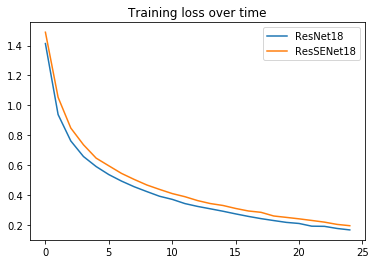

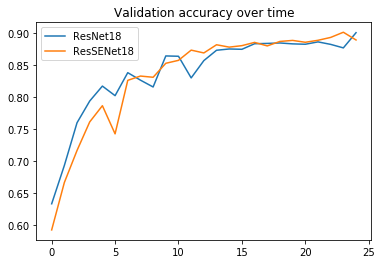

In [7]:
accResNet = np.load('./plot/resnetSGDdecay_val_acc_history.npy', allow_pickle=True)
lossResNet = np.load('./plot/resnetSGDdecay_loss_history.npy', allow_pickle=True)

accResSENet = np.load('./plot/resnetSESGDdecay_val_acc_history.npy', allow_pickle=True)
lossResSENet = np.load('./plot/resnetSESGDdecay_loss_history.npy', allow_pickle=True)



plot_data(accResNet, lossResNet, accResSENet, lossResSENet)

# Chihuahua and Muffin Challenge

#### The next task is to take my best ResSENet model to do 8-fold cross-validation on the ChiHuaHua vs Muffins dataset

#### and also load more ChiHuaHua and Muffins images for the test set.

#### For cross-validation I created another train function by editing the old train function to return 
#### max(train_acc_history), max(val_acc_history), min(loss_acc_history), loss_acc_history, val_acc_history

In [31]:
# train_cv.py
# train function for cross-validation

def train_model_cv(model, dataloaders, criterion, optimizer, num_epochs, device):
    '''
    train_model: train a model on a dataset
    
            Parameters:
                    model: Pytorch model
                    dataloaders: dataset
                    criterion: loss function
                    optimizer: update weights function
                    num_epochs: number of epochs
                    weights_name: file name to save weights
                    is_inception: The model is inception net (Google LeNet) or not

            Returns:
                    model: Best model from evaluation result
                    val_acc_history: evaluation accuracy history
                    loss_acc_history: loss value history
    '''
    since = time.time()

    val_acc_history = []
    train_acc_history = []
    loss_acc_history = []

    best_acc = 0.0

    for epoch in range(num_epochs):
        epoch_start = time.time()

        # print('Epoch {}/{}'.format(epoch, num_epochs - 1))
        # print('-' * 10)

        # Each epoch has a training and validation phase
        for phase in ['train', 'val']:
            if phase == 'train':
                model.train()  # Set model to training mode
            else:
                model.eval()   # Set model to evaluate mode

            running_loss = 0.0
            running_corrects = 0

            # Iterate over data.
            for inputs, labels in dataloaders[phase]:
                # for process anything, device and dataset must put in the same place.
                # If the model is in GPU, input and output must set to GPU
                inputs = inputs.to(device)
                labels = labels.to(device)

                # zero the parameter gradients
                # it uses for update training weights
                optimizer.zero_grad()

                # forward
                # track history if only in train
                with torch.set_grad_enabled(phase == 'train'):
                    # Get model outputs and calculate loss
                    # Special case for inception because in training it has an auxiliary output. In train
                    #   mode we calculate the loss by summing the final output and the auxiliary output
                    #   but in testing we only consider the final output.
                    outputs = model(inputs)
                    loss = criterion(outputs, labels)

                    _, preds = torch.max(outputs, 1)

                    # print("Labels : ", labels)
                    # print("Preds : ", preds)

                    # backward + optimize only if in training phase
                    if phase == 'train':
                        loss.backward()
                        optimizer.step()

                # statistics
                running_loss += loss.item() * inputs.size(0)
                running_corrects += torch.sum(preds == labels.data)

            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_acc = running_corrects.double() / len(dataloaders[phase].dataset)
            epoch_end = time.time()
            
            elapsed_epoch = epoch_end - epoch_start

            # print('{} Loss: {:.4f} Acc: {:.4f}'.format(phase, epoch_loss, epoch_acc))
            # print("Epoch time taken: ", elapsed_epoch)

            # deep copy the model
            if phase == 'val' and epoch_acc > best_acc:
                best_acc = epoch_acc
                # best_model_wts = deepcopy(model.state_dict())
                # torch.save(model.state_dict(), weights_name + ".pth")
            if phase == 'val':
                val_acc_history.append(epoch_acc)
            if phase == 'train':
                train_acc_history.append(epoch_acc)
                loss_acc_history.append(epoch_loss)


    time_elapsed = time.time() - since
    # print('Training complete in {:.0f}m {:.0f}s'.format(time_elapsed // 60, time_elapsed % 60))
    # print('Best val Acc: {:4f}'.format(best_acc))

    # load best model weights
    # model.load_state_dict(best_model_wts)
    # return model, val_acc_history, loss_acc_history

    # print(train_acc_history)
    # print(loss_acc_history)
    return max(train_acc_history), max(val_acc_history), min(loss_acc_history), loss_acc_history, val_acc_history

#### I also edited the test function to also return the inputs, preds, labels
#### so that I can compare the predicted labels with the real label and also show the images
#### to hopefully study the performance of the model

In [32]:
def test_model_chimuff(model, dataloaders, criterion, device):
    '''
    train_model function

    Train a PyTorch model for a given number of epochs.
    
            Parameters:
                    model: Pytorch model
                    dataloaders: dataset
                    criterion: loss function
                    optimizer: update weights function
                    num_epochs: number of epochs
                    weights_name: file name to save weights
                    is_inception: The model is inception net (Google LeNet) or not

            Returns:
                    model: Best model from evaluation result
                    val_acc_history: evaluation accuracy history
                    loss_acc_history: loss value history
    '''
    model.eval()   # Set model to evaluate mode

    running_loss = 0.0
    running_corrects = 0
            
    for inputs, labels in dataloaders['test']:

        # Inputs is one batch of input images, and labels is a corresponding vector of integers
        # labeling each image in the batch. First, we move these tensors to our target device.
        
        inputs = inputs.to(device)
        labels = labels.to(device)

        outputs = model(inputs)
        loss = criterion(outputs, labels)

        _, preds = torch.max(outputs, 1)

        # Gather our summary statistics        
        running_loss += loss.item() * inputs.size(0)
        running_corrects += torch.sum(preds == labels.data)

    test_loss = running_loss / len(dataloaders['test'].dataset)
    test_acc = running_corrects.double() / len(dataloaders['test'].dataset)
    test_end = time.time()

    print('{} Loss: {:.4f} Acc: {:.4f}'.format('test', test_loss, test_acc))

    return test_acc, test_loss, inputs, preds, labels

## Loading and Splitting the images

#### I used ImageFolder and dataloader to load all 16 images into 1 tensor variable so that I can use my own function to split them.
#### According to the instruction we need to split the images into train and validation set, with the validation set containing only one image from each class, so total of 2 images, one image of Chihuahua and one image of a muffin. ( holding out two examples from each category as the validation set each time)
#### I wrote a very very manual and basic function to split the data into train and validation set, accordingly.
#### I can call this function before I do each fold and each time it will gives me a newly randomized train_loader and validation_loader of the data.

#### For the transformation of the data I used RandomCrop, RandomHorizontalFlip anbd Normalize them with mean = 0.5 and std = 0.5 in all dimensions.


In [33]:
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.RandomCrop(224),
    transforms.RandomHorizontalFlip(),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))])

# load the data
dataset = datasets.ImageFolder('/root/labs/data/chivsmuff', transform=transform)
dataloader = torch.utils.data.DataLoader(dataset, batch_size = 16) # get all 16 images into 1 batch

# get all 16 images and labels as a tensor variable
dataiter = iter(dataloader)
img, label = dataiter.next()

# Filter the images by the labels
img_0 = img[label==0]
img_1 = img[label==1]
label_0 = label[label==0]
label_1 = label[label==1]

# count the number of images in each class
num_data0 = len(img_0)
num_data1 = len(img_1)

# a function to get a newly randomized train and validation set every fold
def get1folddata():
    range_idx0 = np.arange(num_data0)
    range_idx1 = np.arange(num_data1)

    # random the index of the validation images, 1 image from each class
    idx_val0 = random.randint(0,num_data0-1)
    idx_val1 = random.randint(0,num_data1-1)

    # the other index will be the training set
    train_idx0 = range_idx0!=idx_val0
    train_idx1 = range_idx1!=idx_val1

    validation_img = torch.cat([img_0[idx_val0].reshape(1,3,224,224),img_1[idx_val1].reshape(1,3,224,224)],dim=0)
    train_img = torch.cat([img_0[train_idx0].reshape(-1,3,224,224), img_1[train_idx1].reshape(-1,3,224,224)],dim=0)

    validation_label = torch.Tensor([label_0[idx_val0],label_1[idx_val1]]).long()
    train_label = torch.cat([label_0[train_idx0], label_1[train_idx1]],dim=0).long()

    train_ds = TensorDataset(train_img, train_label)
    validation_ds = TensorDataset(validation_img, validation_label)

    train_loader = torch.utils.data.DataLoader(train_ds, batch_size = 14, shuffle=True)
    validation_loader = torch.utils.data.DataLoader(validation_ds, batch_size = 2, shuffle=True)

    # return as dataloaders, so we can use them for training right away
    return train_loader, validation_loader


## Implement 8-fold cross-validation 8 times to train 8 models to find the best hyperparameters

In [40]:
# we will do 8 fold
kfold = 8

# get the validation accuracy, loss history and validation accuracy from each fold of all 8 models
all_max_val_acc = []
all_loss_history = []
all_val_acc_history = []

# Here is the list of parameters that I will try for the 8 models
optim_list          = ['SGD','SGD', 'SGD', 'SGD', 'Adam', 'Adam', 'Adam', 'Adam']
lr_list             = [0.001, 0.005, 0.001, 0.005, 0.001, 0.001, 0.005, 0.005] 
weight_decay_list   = [0.0005, 0.0005, 0.0005, 0.0005, 0, 0.0005, 0 , 0.0005]  
momentum_list       = [0, 0, 0.9, 0.9, 0, 0, 0, 0, 0, 0]

In [41]:
for j in range(len(optim_list)): # j is the number of models we want to try, in this case it is 8
    
    # get the validation accuracy, loss history and validation accuracy
    # from each fold
    max_val_acc_each_fold = []
    loss_history_each_fold = []
    vall_acc_history_each_fold = []

    print(f"Model {j}")

    for i in range(kfold): # i is the number of fold we want to do

        # get a random train and validation set for training in this fold
        train_loader, validation_loader = get1folddata()
        dataloaders = {'train': train_loader, 'val': validation_loader}

        # Load the best ResSENet that I have trained from the first part of the lab
        # which is this model 'resnetSESGDdecay_bestsofar.pth'
        resnet = ResSENet18().to(device)
        resnet.load_state_dict(torch.load('../../weights/resnet/resnetSESGDdecay_bestsofar.pth'))

        criterion = nn.CrossEntropyLoss()
        params_to_update = resnet.parameters()

        # loop through all the optimizer and hyperparameters that we want to try
        if optim_list[j] == 'SGD':
            optimizer = optim.SGD(params_to_update, lr = lr_list[j], weight_decay=weight_decay_list[j], momentum = momentum_list[j])
        else :
            optimizer = optim.Adam(params_to_update, lr = lr_list[j], weight_decay=weight_decay_list[j])

        # train each model
        max_train_acc, max_val_acc, min_train_loss, loss_history, val_acc_history = train_model_cv(model = resnet,
                                                                dataloaders = dataloaders,
                                                                criterion = criterion,
                                                                optimizer = optimizer,
                                                                num_epochs = 20,
                                                                device = device)

        max_val_acc_each_fold.append(max_val_acc)
        loss_history_each_fold.append(loss_history)
        vall_acc_history_each_fold.append(val_acc_history)

        print(f"Fold {i} | max train acc {max_train_acc} | max val acc {max_val_acc} | min train loss {min_train_loss}")

    all_max_val_acc.append(max_val_acc_each_fold)
    all_loss_history.append(loss_history_each_fold)
    all_val_acc_history.append(vall_acc_history_each_fold)

all_max_val_acc = np.array(all_max_val_acc)
all_loss_history = np.array(all_loss_history)
all_val_acc_history = np.array(all_val_acc_history)


Model 0
Fold 0 | max train acc 1.0 | max val acc 0.5 | min train loss 0.13456587493419647
Fold 1 | max train acc 1.0 | max val acc 0.0 | min train loss 0.12191752344369888
Fold 2 | max train acc 1.0 | max val acc 0.0 | min train loss 0.13836224377155304
Fold 3 | max train acc 1.0 | max val acc 0.5 | min train loss 0.1490909904241562
Fold 4 | max train acc 1.0 | max val acc 1.0 | min train loss 0.13695092499256134
Fold 5 | max train acc 1.0 | max val acc 1.0 | min train loss 0.13695146143436432
Fold 6 | max train acc 1.0 | max val acc 0.0 | min train loss 0.14626048505306244
Fold 7 | max train acc 1.0 | max val acc 0.5 | min train loss 0.15389351546764374
Model 1
Fold 0 | max train acc 1.0 | max val acc 0.0 | min train loss 0.02509992942214012
Fold 1 | max train acc 1.0 | max val acc 1.0 | min train loss 0.02550582028925419
Fold 2 | max train acc 1.0 | max val acc 1.0 | min train loss 0.02579568699002266
Fold 3 | max train acc 1.0 | max val acc 0.0 | min train loss 0.025099897757172585


In [42]:
print(all_max_val_acc.shape)
print(all_loss_history.shape)
print(all_val_acc_history.shape)

(8, 8)
(8, 8, 20)
(8, 8, 20)


## Results & Get the index of the model with the highest Average Validation Accuracy

In [54]:
#Get the model with the Highest avarage validation accuracy over 8 folds
mean_val_acc = np.mean(all_max_val_acc, axis = 1 )
print("Average Validation Accuracy of each model\n", mean_val_acc)

idx_best_model = np.argmax(mean_val_acc)
print("Index of the best model : ", idx_best_model)

Average Validation Accuracy of each model
 [tensor(0.4375, device='cuda:0', dtype=torch.float64)
 tensor(0.4375, device='cuda:0', dtype=torch.float64)
 tensor(0.8125, device='cuda:0', dtype=torch.float64)
 tensor(0.8125, device='cuda:0', dtype=torch.float64)
 tensor(0.6250, device='cuda:0', dtype=torch.float64)
 tensor(0.6875, device='cuda:0', dtype=torch.float64)
 tensor(0.5625, device='cuda:0', dtype=torch.float64)
 tensor(0.5625, device='cuda:0', dtype=torch.float64)]
Index of the best model :  2


#### From Average Validation Accuracy, the best model are the models with index 2 and 3
#### In this case, I will take the model with index 3 to fine-tune the model.
#### Because looking from the printed training loss above, model 3 has much lower training loss than model 2.

In [74]:
idx_best_model = 3

print(f"The best optimizer is {optim_list[idx_best_model]} with the following hyperparameters : ")

if optim_list[idx_best_model]== 'SGD':
    print(f"optimizer = optim.SGD(params_to_update, lr = {lr_list[idx_best_model]}, weight_decay = {weight_decay_list[idx_best_model]}, momentum = {momentum_list[idx_best_model]})")
else :
    print(f"optimizer = optim.Adam(params_to_update, lr = {lr_list[idx_best_model]}, weight_decay = {weight_decay_list[idx_best_model]})")

The best optimizer is SGD with the following hyperparameters : 
optimizer = optim.SGD(params_to_update, lr = 0.005, weight_decay = 0.0005, momentum = 0.9)


## Plotting the Training loss and Validaton Accuracy of the 8 models
#### Here, I only plot 1 fold as an example

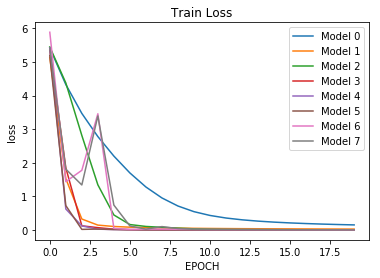

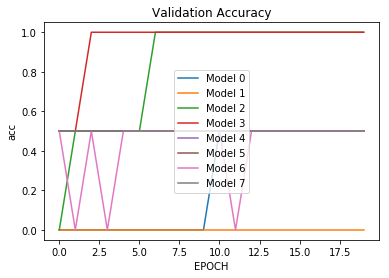

In [53]:
def plot_cv(all_loss_history, all_val_acc_history):
    for i in range(all_loss_history.shape[0]):
        plt.plot(all_loss_history[i,3,:], label=f"Model {i}")
    plt.title("Train Loss")
    plt.ylabel("loss")
    plt.xlabel("EPOCH")
    plt.legend()
    plt.show()
    for i in range(all_val_acc_history.shape[0]):
        plt.plot(all_val_acc_history[i,3,:], label=f"Model {i}")
    plt.title("Validation Accuracy")
    plt.ylabel("acc")
    plt.xlabel("EPOCH")
    plt.legend()
    plt.show()

plot_cv(all_loss_history, all_val_acc_history)

## Use the model with Highest Average Accuracy to fine-tune the ResSENet18 model again with all data in the dataset as the training set

In [75]:
train_loader = torch.utils.data.DataLoader(dataset, batch_size = 14, shuffle=True)
valid_loader = torch.utils.data.DataLoader(dataset, batch_size = 14, shuffle=True)
dataloaders = {'train': train_loader, 'val': valid_loader}

resnet = ResSENet18().to(device)
resnet.load_state_dict(torch.load('../../weights/resnet/resnetSESGDdecay_bestsofar.pth')) # load the trained model to strat fine-tuning again

criterion = nn.CrossEntropyLoss()
params_to_update = resnet.parameters()

# use idx_best_model to choose the best hyperparameters from our list
if optim_list[idx_best_model] == 'SGD':
        optimizer = optim.SGD(params_to_update, lr = lr_list[idx_best_model], weight_decay=weight_decay_list[idx_best_model], momentum = momentum_list[idx_best_model])
else :
        optimizer = optim.Adam(params_to_update, lr = lr_list[idx_best_model], weight_decay=weight_decay_list[idx_best_model])

best_model, val_acc_history, loss_history = train_model(model = resnet,
                                                            dataloaders = dataloaders,
                                                            criterion = criterion,
                                                            optimizer = optimizer,
                                                            num_epochs = 25,
                                                            device = device, 
                                                            weights_name='CHIMUFF')

val_acc_history = np.array(val_acc_history)
np.save('CHIMUFF_val_acc_history.npy', val_acc_history)

loss_history = np.array(loss_history)
np.save('CHIMUFF_loss_history.npy', loss_history)

Epoch 0/24
----------
train Loss: 5.2596 Acc: 0.0625
Epoch time taken:  0.1707744598388672
val Loss: 1.3479 Acc: 0.4375
Epoch time taken:  0.27193713188171387

Epoch 1/24
----------
train Loss: 1.1967 Acc: 0.7500
Epoch time taken:  0.17356443405151367
val Loss: 4.1282 Acc: 0.5625
Epoch time taken:  0.2862224578857422

Epoch 2/24
----------
train Loss: 0.2579 Acc: 0.8750
Epoch time taken:  0.17151665687561035
val Loss: 15.4063 Acc: 0.5000
Epoch time taken:  0.28405165672302246

Epoch 3/24
----------
train Loss: 0.6192 Acc: 0.7500
Epoch time taken:  0.16095900535583496
val Loss: 0.5646 Acc: 0.8750
Epoch time taken:  0.2721226215362549

Epoch 4/24
----------
train Loss: 0.7875 Acc: 0.8125
Epoch time taken:  0.1696150302886963
val Loss: 3.1779 Acc: 0.8125
Epoch time taken:  0.28310322761535645

Epoch 5/24
----------
train Loss: 0.2296 Acc: 0.8750
Epoch time taken:  0.1676313877105713
val Loss: 4.3349 Acc: 0.6875
Epoch time taken:  0.28139805793762207

Epoch 6/24
----------
train Loss: 0.69

#### The model got the best validation accuracy = 100% !

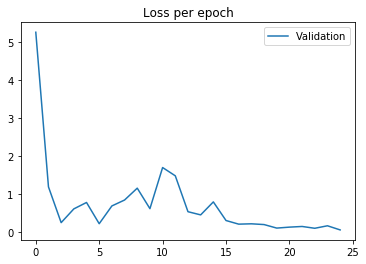

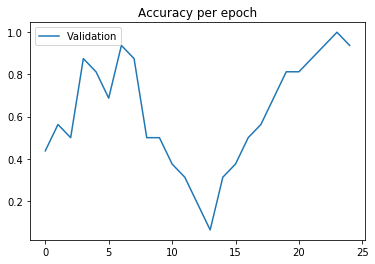

In [76]:
def plot_data(val_acc_history, loss_acc_history):
    plt.plot(loss_acc_history, label = 'Validation')
    plt.title('Loss per epoch')
    plt.legend()
    plt.show()
    plt.plot(val_acc_history, label = 'Validation')
    plt.title('Accuracy per epoch')
    plt.legend()
    plt.show()

acc = np.load('./plot/CHIMUFF_val_acc_history.npy', allow_pickle=True)
loss = np.load('./plot/CHIMUFF_loss_history.npy', allow_pickle=True)
plot_data(acc, loss)

## Test the final fine-tuned model with Chihuahua and Muffin images that I downloaded from the internet that are not the same with the ones in the dataset



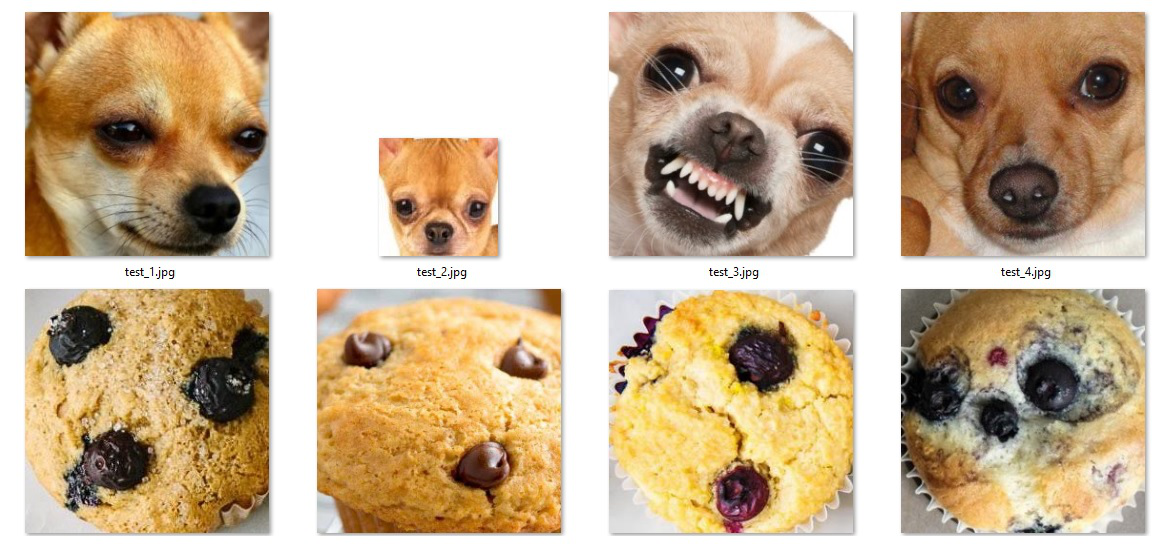

In [61]:
# the test images I used
# There are 4 images in each class
display(Image.open("test.jpg"))

In [67]:
# Load the fine-tuned model
resnet.load_state_dict(torch.load('../../weights/resnet/CHIMUFF.pth'))

test_dataset = datasets.ImageFolder('test', transform=transform) # used the same transformation the resize and crop the images

test_dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 8, shuffle=True) # load all 8 images into 1 batch
test_dataloaders = { 'test': test_dataloader }

test_acc, test_loss, inputs, preds, labels = test_model_chimuff(resnet, test_dataloaders, criterion, device)

# Check the unique predicted class
# I did not modified the ResSENet18 to output 2 class
# so there is still a possibility that it will out put other classes other than 0 and 1
# So I want to check the model performance if it will output other classes
print("Unique predicted labels : ", np.unique(preds.cpu().detach().numpy()))

test Loss: 0.0027 Acc: 1.0000
Unique predicted labels :  [0 1]


#### The model only predict class 0 and 1 which is a good sign!
#### It also got test set accuracy of 100%

## Plot to see the images and their predicted class

In [71]:
classes = ['Chi','Muff', 2,3,4,5,6,7,8,9]

correct_im = inputs[labels==preds].cpu().detach().numpy()

correct_im = np.transpose(correct_im, (0,2,3,1))
correct_im = (1/(2*2.25)) * correct_im + 0.5

num_correct = correct_im.shape[0]
real_label = labels[labels==preds].cpu().detach().numpy()
preds_label = preds[labels==preds].cpu().detach().numpy()
real_label = [ classes[i] for i in real_label]
preds_label = [ classes[i] for i in preds_label]

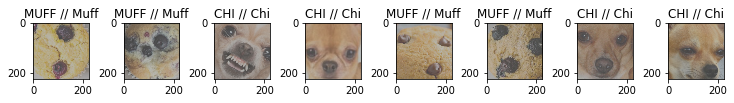

In [72]:
rows = 1
cols = num_correct
axes = []
fig = plt.figure(figsize=(10,10))
for a in range(rows*cols):
    axes.append(fig.add_subplot(rows, cols, a+1) )
    subplot_title = (f"{real_label[-a].upper()} // {preds_label[-a]}")
    axes[-1].set_title(subplot_title)
    plt.imshow(correct_im[-a])
    fig.tight_layout(pad=0)
    fig.show()

#### Since we got test set accuracy of 100% the labels were all predicted correctly.
#### The class name in upppercase letters are the Real Labels and the predicted labels are in lowercase letters.

# Conclusion

Eventhough, in this notebook I got 100% accuracy for the test set, from many other times that I ran this code, the validation accuracy and the test accuracy were always fluctuated. Sometimes 62.5% and sometimes 75%.

But still, the test accuracy are always higher than 50% so it is definitely better than just guessing.

This means that transfer learning from a trained model to another dataset that it has never seen before is possible, as shown in this lab.

There might be something else that can improve this transfer learning, such as increaseing the size of training and validation data, modifying the model artchitecture to output 2 classes, some data augmentation or exploring more hyperparameters of the optimizer.

In this lab, I learned about the components of ResNet and ResSENet which is basically a combination of basic residual blocks and SE blocks. 
And more about implementing k-fold and cross-validation to find the best hyperparameters.

